This script generates hillslope mesh with a varying organic layer thickness at the top.

In [1]:
# Importing all the package needed to run teh watershed workflow
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import shapely
import logging
import copy
import sys
import exodus3
import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.condition
watershed_workflow.ui.setup_logging(1,None)
crs=None

In [2]:
def create_skew_sigmoid_hillslope_multi(
    x_start, x_end, z_top, z_bottom,
    num_points, x0_frac=0.3, k=0.1,
    densify_ranges=None  # (start, end, factor)
):
    """
    Create a left-skewed sigmoid-shaped hillslope profile with optional multiple
    densification bands. Each band is (start, end, factor) where factor>=2
    means 'factor' times the base resolution inside that band.
    """
    # Base grid and spacing
    x_uniform = np.linspace(x_start, x_end, num_points)
    print(x_uniform)
    step = (x_end - x_start) / (num_points - 1)

    # Snap bands to the grid
    snapped_bands = []
    if densify_ranges is None:
        densify_ranges = []
    for s, e, f in densify_ranges:
        if f is None or f < 2:
            continue
        s_snap = x_start + round((s - x_start)/step) * step
        e_snap = x_start + round((e - x_start)/step) * step
        if e_snap <= s_snap:  # ignore empty/invalid
            continue
        # clamp to domain
        s_snap = max(s_snap, x_start)
        e_snap = min(e_snap, x_end)
        if e_snap > s_snap:
            snapped_bands.append((s_snap, e_snap, int(f)))

    # For each base interval [x_i, x_{i+1}] decide the local factor
    factors = np.zeros(len(x_uniform) - 1, dtype=int)
    if len(snapped_bands) > 0:
        # Use the interval midpoint to test inclusion in a band
        mids = 0.5 * (x_uniform[:-1] + x_uniform[1:])
        for s, e, f in snapped_bands:
            in_band = (mids >= s) & (mids <= e)
            factors[in_band] = np.maximum(factors[in_band], f)

    # Build the refined x by subdividing each base interval
    xs = []
    for i in range(len(x_uniform) - 1):
        left, right = x_uniform[i], x_uniform[i + 1]
        m = int(factors[i])  # subdivisions factor
        # Emit m sub-steps, excluding the right endpoint to avoid duplicates
        xs.append(np.linspace(left, right, m + 1, endpoint=False))
    xs.append(np.array([x_uniform[-1]]))  # finally add the last endpoint
    x_all = np.concatenate(xs)

    # Sigmoid z
    x0 = x_start + x0_frac * (x_end - x_start)
    z = z_bottom + (z_top - z_bottom) / (1 + np.exp(k * (x_all - x0)))

    return pd.DataFrame({"x": x_all, "z": z})

In [3]:
def create_skew_sigmoid_hillslope(x_start, x_end, z_top, z_bottom, 
                                   num_points, x0_frac=0.3, k=0.1):
    """
    Create a left-skewed sigmoid-shaped hillslope profile.
    """
    x0 = x_start + x0_frac * (x_end - x_start)
    x = np.linspace(x_start, x_end, num_points)
    print(x)
    z = z_bottom + (z_top - z_bottom) / (1 + np.exp(k * (x - x0)))
    return pd.DataFrame({"x": x, "z": z})

In [4]:
def elliptical_lake_profile(x, lake_left=40, lake_right=60, max_depth=4.0):
    """
    Create a 1D plain (z=0) with an elliptical-arc lake between lake_left and lake_right.
    The lake is a half-ellipse with maximum depth 'max_depth' at the midpoint.

    Parameters
    ----------
    x_start, x_end : float
        Domain limits for x.
    num_points : int
        Number of samples across the domain.
    lake_left, lake_right : float
        Horizontal extents of the lake (shoreline where z returns to 0).
    max_depth : float
        Maximum depth (positive number) at the lake center.

    Returns
    -------
    pandas.DataFrame with columns ['x','z']
    """
    if lake_right <= lake_left:
        raise ValueError("lake_right must be greater than lake_left.")
    if max_depth < 0:
        raise ValueError("max_depth must be positive.")

    a = 0.5 * (lake_right - lake_left)   # horizontal semi-axis
    b = float(max_depth)                 # vertical semi-axis (depth)
    x0 = 0.5 * (lake_left + lake_right)  # center    
    z = np.zeros_like(x, dtype=float)
    mask = (x >= lake_left) & (x <= lake_right)
    # z(x) for the lower half of an ellipse centered at z=0
    under = 1.0 - ((x[mask] - x0) / a) ** 2
    under = np.clip(under, 0.0, None)  # numerical safety at the endpoints
    z[mask] = -b * np.sqrt(under)

    return pd.DataFrame({"x": x, "z": z})

In [5]:
# Here we have 2 regions that have higher density. 
# Just change 4 to 1 and/or 2 to 1 if you don't want redensify
# Original density is 1m, change num_points if you want other resolution
df_skew = create_skew_sigmoid_hillslope_multi(
    x_start=0, x_end=500, z_top=20, z_bottom=0, num_points=101, x0_frac=0.4, k=0.015,
    )
    #densify_ranges=((15, 20, 4), (43, 57, 2))

# max_depth is the depth of the lake
df_eclipse = elliptical_lake_profile(
    df_skew.x, lake_left=40, lake_right=60, max_depth=0
    )
print(f'Num nodes = {len(df_skew.x)}')

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495. 500.]
Num nodes = 101


In [6]:
df_skew.z

0      19.051483
1      18.981371
2      18.906374
3      18.826197
4      18.740533
         ...    
96      0.295481
97      0.274423
98      0.254847
99      0.236651
100     0.219739
Name: z, Length: 101, dtype: float64

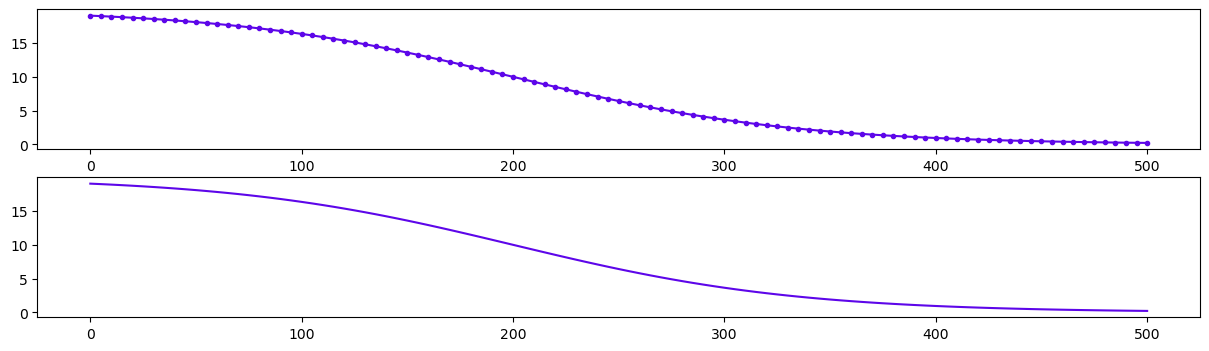

In [7]:
fig,ax = plt.subplots(2,1,figsize=(15,4))
ax[0].plot(df_skew.x, df_skew.z+df_eclipse.z,'-o',ms=3)
ax[1].plot(df_skew.x, df_skew.z+df_eclipse.z)

In [8]:
x = df_skew.x
z = df_skew.z + df_eclipse.z
print(x)
print(z)
m2 = watershed_workflow.mesh.Mesh2D.from_Transect(x.to_numpy(),z.to_numpy())
print(f'Creating m2 mesh with {len(m2.conn)} elements.')

0        0.0
1        5.0
2       10.0
3       15.0
4       20.0
       ...  
96     480.0
97     485.0
98     490.0
99     495.0
100    500.0
Name: x, Length: 101, dtype: float64
0      19.051483
1      18.981371
2      18.906374
3      18.826197
4      18.740533
         ...    
96      0.295481
97      0.274423
98      0.254847
99      0.236651
100     0.219739
Name: z, Length: 101, dtype: float64
Creating m2 mesh with 100 elements.


In [9]:
coordinate = m2.centroids[:, :2]

In [10]:
## Surface : Plateau - 11 / Slope - 12 / Baxio - 13
veg_labels_dict = dict(zip([11, 12, 13], ['Plateau', 'Slope', 'Baxio']))

veg_colors = []
for i in range(len(m2.centroids)):
    if m2.centroids[i, 0] <= 25:
        veg_colors.append(11)
    elif m2.centroids[i, 0] >= 75:
        veg_colors.append(13)
    else:
        veg_colors.append(12)
        
veg_colors = np.array(veg_colors)

# This source code from the .regions.add_nlcd_labeled_sets 
inds = np.unique(veg_colors)

if veg_labels_dict is None:
    veg_labels_dict = dict((i, str(i)) for i in inds)

for ind in inds:
    ent_ids = list(np.where(veg_colors == ind)[0])
    ls = watershed_workflow.mesh.LabeledSet(veg_labels_dict[ind], int(ind), 'CELL', ent_ids)
    m2.labeled_sets.append(ls)

In [11]:
# Function to create mesh for topsoil layers (1.2m)
def topsoil():
    dz0 = 0.05
    r = 1.2
    dz_values = dz0 * (r ** np.arange(10))
    return dz_values

In [12]:
# Function to create mesh for bottom layers (varied in space)
def layer2(x1, y1):
    # ind = x.astype(int)
    toplayer_bottom_elev = np.sum(topsoil())
    if x1==0:
        ind = 0
    else:
        ind = np.where(x==x1)[0][0] - 1
    value = (z[ind] - toplayer_bottom_elev - 4)/10.
    return value

In [19]:
dzs = [ [0.05,]*4, [0.1,]*4, [0.2,]*3, [0.4,]*2, [1.0,]*8]
dzs = [i for j in dzs for i in j]
print(dzs)
nz = len(dzs)
print(nz, sum(dzs))

# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

for i, dz in enumerate(dzs):
    #if i <= 9:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_mat_ids.append(1001)
    #else:
    #    layer_types.append('function')
    #    layer_data.append(dz)
    #    layer_mat_ids.append(1001)
        
    layer_ncells.append(1)
    
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, layer_ncells, layer_mat_ids)


[0.05, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.4, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
21 10.0


In [20]:
# Set subsurface regions
mat_c = []
for i in range(len(m2.centroids)):
    if m2.centroids[i, 0] <= 25:
        mat_c.append(101)
    elif m2.centroids[i, 0] >= 75:
        mat_c.append(103)
    else:
        mat_c.append(102)

mat_ids = []
for i in range(30): # dz layers 
    mat_ids.append(mat_c)
mat_ids = np.array(mat_ids)

#### Subsurface : Plateau - 101 / Slope - 102 / Baxio - 103
mesh2D = m2
layer_types = layer_types
layer_data = layer_data
ncells_per_layer = layer_ncells
np_mat_ids = mat_ids

material_ids = np.zeros((m3.num_cells, ), 'i')

ncells_tall = sum(ncells_per_layer)
ncells_total = ncells_tall * mesh2D.num_cells
cells = [list() for c in range(ncells_total)]

eh = watershed_workflow.mesh._ExtrusionHelper(ncells_tall, mesh2D.num_cells)

for col in range(mesh2D.num_cells):
    z_cell = 0
    for ilay in range(len(ncells_per_layer)):
        ncells = ncells_per_layer[ilay]
        for i in range(z_cell, z_cell + ncells):
            material_ids[eh.col_to_id(col, i)] = np_mat_ids[ilay, col]
        z_cell = z_cell + ncells

m3.material_ids = material_ids
m3.material_ids_list[:] = list(np.unique(material_ids))

In [21]:
# Save mesh 
filename = '../data/gradient_hillslope0.exo'
if os.path.exists(filename):
    os.remove(filename)
m3.writeExodus(filename)

2025-08-13 00:02:34,405 - root - INFO: adding side set: 1
2025-08-13 00:02:34,406 - root - INFO: adding side set: 2
2025-08-13 00:02:34,407 - root - INFO: adding side set: 3
2025-08-13 00:02:34,471 - root - INFO: adding side set: 11
2025-08-13 00:02:34,472 - root - INFO: adding side set: 12
2025-08-13 00:02:34,473 - root - INFO: adding side set: 13



You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ../data/gradient_hillslope0.exo
Closing exodus file: ../data/gradient_hillslope0.exo
